# Normal conditional distribution paradox

It is highly intuitively appealing that if three components of a random vector are highly positively correlated, then within any pair of components conditioned on the third, the correlation would also be positive. In fact, it is not so. which might be thought of as a paradox.

Denote $N_{\mu,S}$ a joint normal CDF with mean $\mu$ and covariance matrix $S$.

First show this effect using sampling. Let $X$ be a normal (Gaussian) random vector with zero mean and covariance matrix (that is, with CDF $N_{0, S}$)

$$
S = \left(
\begin{array}{ccc}
1&0.9&0.9\\
0.9&1&0.63\\
0.9&0.63&1
\end{array}
\right)
$$

In [1]:
import pandas as pd
import scipy.stats as ss
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
s = pd.DataFrame([[1, 0.9, 0.9], [0.9, 1, 0.63], [0.9, 0.63, 1]])

In [3]:
np.linalg.det(s)

0.003699999999999962

In [4]:
# create a sample from multivariate normal distribution
n_trials = 100000
x = pd.DataFrame(ss.multivariate_normal.rvs(cov=s, size=n_trials))

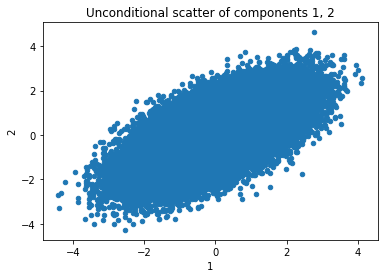

In [5]:
# scatter the components 1, 2
x.plot.scatter(1, 2);
title('Unconditional scatter of components 1, 2');

In [6]:
# select samples aproximately satisfying the condition x0 == 0
ind = (x[0].abs() <= 0.01)
xp = x[ind]
xp.shape

(795, 3)

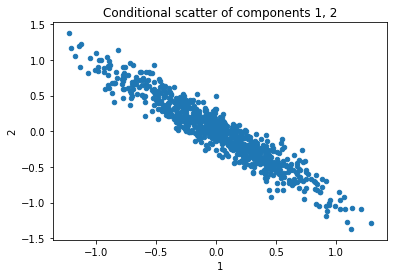

In [7]:
xp.plot.scatter(1, 2);
title('Conditional scatter of components 1, 2');

We see that unconditional and conditional correlations dramatically differ.

Now let's compute the conditional covariance matrix using theoretic representation, e.g. from [Multivariate Normal Distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution):

Denote $I$ a set of indices included in condition, and the rest $J$ would be included in target, then break the random vector and its covariance matrix as follows:

$$
X = \left(
\begin{array}{c}
X_I\\ X_J
\end{array}
\right),\;\;\;\;
S = \left(
\begin{array}{cc}
S_{II}&S_{IJ}\\S_{JI}&S_{JJ}
\end{array}
\right).
$$

The conditional distribution of $X_J$ given $X_I=x_I$ is joint normal with mean and covariance matrix

$$
\mu_{J|I}(x_I)=E(X_J|X_I=x_I)=S_{JI}S_{II}^{-1}x_I,\;\; S_{J|I}=cov(X_J|X_I=x_I)=S_{JJ}-S_{JI}S_{II}^{-1}S_{IJ}.
$$

In other words, the CDF of this conditional distribution is $N_{\mu_{J|I}(x_I), S_{J|I}}$.

For $x_I=0$ we have $\mu_{J|I}(x_I)=0$ and

$$
S_{J|I}=
\left(
\begin{array}{cc}
1&0.63\\ 0.63&1
\end{array}
\right)
-\left(
\begin{array}{c}
0.9\\0.9
\end{array}
\right)
\left(
\begin{array}{cc}
0.9&0.9
\end{array}
\right)=
\left(
\begin{array}{cc}
0.19&-0.18\\
-0.18&0.19
\end{array}
\right)
$$

Let's verify this numerically:

In [8]:
II = [0]
JJ = [1, 2]

def cond_params(II, JJ, s):
    """ """
    sII = s.iloc[II, II]
    sIJ = s.iloc[II, JJ]
    sJI = s.iloc[JJ, II]
    sJJ = s.iloc[JJ, JJ]
    sIIinv = pd.DataFrame(np.linalg.inv(sII), index=II, columns=II)
    mupr = sJI.dot(sIIinv)
    #mupr = pd.DataFrame(mup, index=sJI.index, columns=sJI.columns)
    s_J_I = sJJ - sJI.dot(sIIinv).dot(sIJ)
    return mupr, s_J_I
mupr, s_J_I = cond_params(II, JJ, s)
print(mupr)
print(s_J_I)

     0
1  0.9
2  0.9
      1     2
1  0.19 -0.18
2 -0.18  0.19


Let's check the correlation

In [9]:
def cov_to_corr(c):
    """ convert covariance matrix to correlation one """
    dd = np.diag(1 / np.diag(c) ** 0.5)
    cc = dd.dot(c).dot(dd)
    return pd.DataFrame(cc, index=c.index, columns=c.columns)

In [10]:
cr = cov_to_corr(s_J_I)
print('Pearson correlation matrix')
print(cr)

Pearson correlation matrix
          1         2
1  1.000000 -0.947368
2 -0.947368  1.000000


We see that conditional correlation is very close to -1. For future reference also compute Spearman correlation, which for normal distributions are easily related to Pearson ones.

In [11]:
def spearman_from_pearson(r):
    """ convertion for normal multivariate """
    s = 6 / np.pi * np.arcsin(0.5 * r)
    return s

In [12]:
crs = spearman_from_pearson(cr)
print('Spearman correlation matrix')
print(crs)

Spearman correlation matrix
          1         2
1  1.000000 -0.942457
2 -0.942457  1.000000


In [13]:
# check the sample Spearman correlation too
print(xp.corr(method='spearman'))

          0         1         2
0  1.000000 -0.009323  0.029190
1 -0.009323  1.000000 -0.945709
2  0.029190 -0.945709  1.000000


## Normal copula, conditional distribution

Let $F$ be a vector of marginal CDFs of $X$ (all of the are normal), and denote

$$
U=F(X)
$$

the copula random vector; here the transform is understood component-wise (each marginal CDF applies to the corresponding component, producing a vector $U$). The CDF of $U$ is called normal copula, it has uniform marginal distribution.

Consider partitions of $U$ and $F$ similar to that of $X$:

$$
U=\left(
\begin{array}{c}
U_I\\
U_J
\end{array}
\right),\;\;
F=\left(
\begin{array}{c}
F_I\\
F_J
\end{array}
\right),
$$

and conditional distribution

\begin{align}
P\left(\left.U_J\leq u_J\right|U_i=u_I\right) &=
P\left(\left.X_J\leq F_J^{-1}(u_J)\right|X_i=F_I^{-1}(u_I)\right)\\
& = N_{\mu_{J|I}(F_I^{-1}(u_I)), S_{J|I}}\left(F_J^{-1}(u_J)\right)
\end{align}

Thus conditional distribution within copula may be directly represented via multivariate normal distribution characteristics.

In [14]:
# for future using
loc_eps = 0.001

def correct_u(u):
    """ replace 0 and 1 """
    ind0 = (u <= 0)
    ind1 = (u >= 1)
    uu = u.copy()
    uu[ind0] = loc_eps
    uu[ind1] = 1 - loc_eps
    return uu

## Joint distribution

Now consider a joint distribution with normal copula and arbitrary marginals, denote the vector of marginals $G$, with partition to $G_I$ and $G_J$. Denote $Z$ the random vector possessing that distribution.

\begin{align}
P(Z_J\leq z_J|Z_I=z_I) &=P(U_J\leq G_J(z_J)|U_I=G_I(z_I))\\
&= N_{\mu_{J|I}(F_I^{-1}(G_I(z_I)))}(F_J^{-1}(G_J(z_J)))
\end{align}

with $U_I=G_I(Z_I)$, $U_J=G_J(z_J)$.

This distribution is also represented via multivariate normal distribution and marginal CDFs.

## Simulation

Simulate joint distribution with exponential and t marginals

In [15]:
# functions for simulation
def simulate_u(mupr, s_J_I, x_I, n=100000):
    """ """
    # calculate conditional mean, given X_I = x_I
    mu = mupr.dot(x_I)
    
    # simulate normal variates
    cols = s_J_I.columns
    xJ = pd.DataFrame(ss.multivariate_normal.rvs(mean=mu, cov=s_J_I, size=n), columns=cols)
    
    # convert to U's
    uJ = pd.DataFrame(columns=cols)
    for cl in uJ.columns:
        # use original marginals, not conditional ones!!!
        uJ[cl] = ss.norm.cdf(xJ[cl])
    
    return uJ

def simulate_z(uJ, typ='t'):
    """ """
    # transform to original space
    if typ == 't':
        zJ = pd.DataFrame(ss.t.ppf(uJ, df=3), columns=uJ.columns)
    else:
        zJ = pd.DataFrame(ss.expon.ppf(uJ), columns=uJ.columns)
    return zJ


In [16]:
# components 1, 2 conditioned on component 0
II = [0]
JJ = [1, 2]
x_I = pd.Series(0, index=II)
uJ = simulate_u(mupr, s_J_I, x_I)
zJt = simulate_z(uJ)
print('Student t marginals')
print(zJt.corr(method='spearman'))
zJe = simulate_z(uJ, typ='expon')
print('\nExponential marginals')
print(zJe.corr(method='spearman'))

Student t marginals
          1         2
1  1.000000 -0.942524
2 -0.942524  1.000000

Exponential marginals
          1         2
1  1.000000 -0.942524
2 -0.942524  1.000000


As expected, Spearman correlation does not depend on marginal CDF transform, and completely defined by the original conditional covariance $S_{J|I}$.

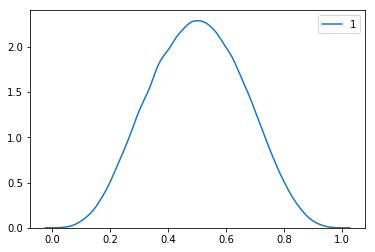

In [17]:
sns.kdeplot(uJ[1]);

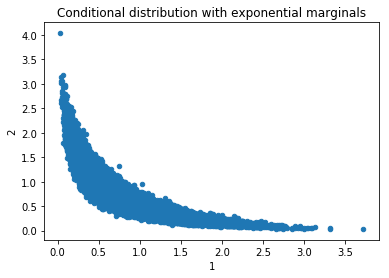

In [18]:
zJe.plot.scatter(1, 2);
title('Conditional distribution with exponential marginals');

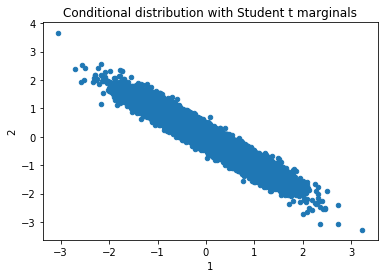

In [19]:
zJt.plot.scatter(1, 2);
title('Conditional distribution with Student t marginals');

## Verify copula conditional using direct sampling

In [20]:
# create multivariate normal
n = 100000
xn = pd.DataFrame(ss.multivariate_normal.rvs(cov=s, size=n))

In [21]:
# convert to U
un = pd.DataFrame(ss.norm.cdf(xn), columns=xn.columns)

In [22]:
def project_on(un, u0=0.5):
    """ project onto u0 = 0.5 """
    ind = ((un[0] - u0).abs() <= 0.01)
    up = un[ind]
    return up

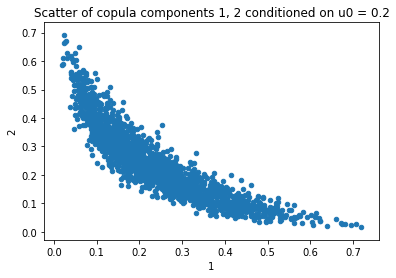

In [23]:
u0=0.2
up = project_on(un, u0=u0)
up.plot.scatter(1, 2);
title('Scatter of copula components 1, 2 conditioned on u0 = {0}'.format(u0));

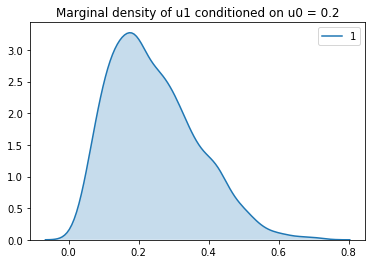

In [24]:
sns.kdeplot(up[1], shade=True);
title('Marginal density of u1 conditioned on u0 = {0}'.format(u0));

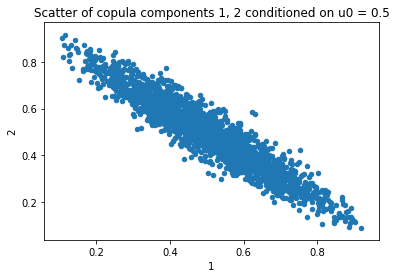

In [25]:
u0=0.5
up = project_on(un, u0=u0)
up.plot.scatter(1, 2);
title('Scatter of copula components 1, 2 conditioned on u0 = {0}'.format(u0));

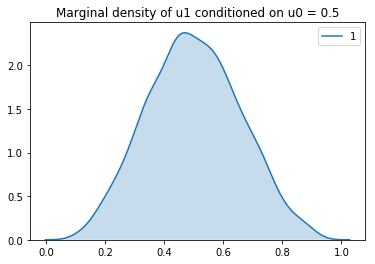

In [26]:
sns.kdeplot(up[1], shade=True);
title('Marginal density of u1 conditioned on u0 = {0}'.format(u0));

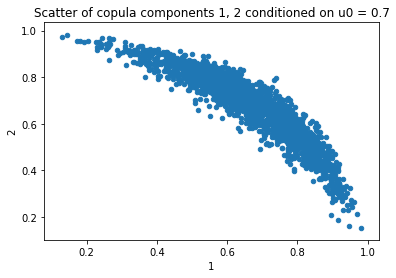

In [27]:
u0=0.7
up = project_on(un, u0=u0)
up.plot.scatter(1, 2);
title('Scatter of copula components 1, 2 conditioned on u0 = {0}'.format(u0));

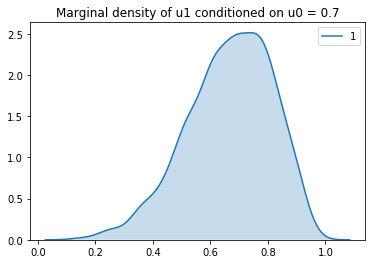

In [28]:
sns.kdeplot(up[1], shade=True);
title('Marginal density of u1 conditioned on u0 = {0}'.format(u0));